Goal here is to refactor np-bragg to a few simple functions. 

1. Image = zeros(n, n)
2. for wavelength in wavelengths:
 - generate indices
 - map indices to detector
 - sum intensities

Populating the interactive namespace from numpy and matplotlib
Detector Distance: 177.856166743295 (mm)


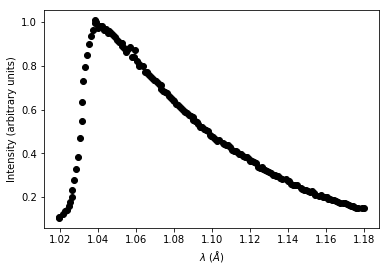

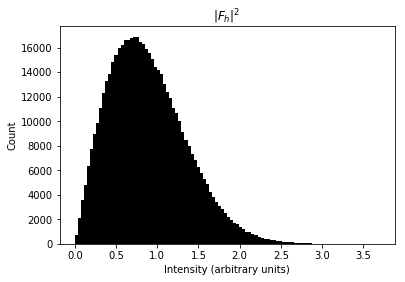

In [8]:
%pylab inline
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm
from scipy.stats import special_ortho_group
from multiprocessing import Pool
import pandas as pd


floattype=np.float32
pixels = 2048 #number of pixels on each axis
pixelsize = .08854 #mm
hmax = 40
maxres = 2.0 #Detector edge
Rs = 0.001
distance_cutoff = 6*Rs
pixel_radius = 20
half_boxsize = 25 #How many pixels around each reflection to calculate scattering
fast_axis = np.array([1, 0, 0], dtype=floattype)
slow_axis = np.array([0, 1, 0], dtype=floattype)

A = np.array([
    [30., 0., 0.],
    [ 0.,40., 0.],
    [ 0., 0.,90.],
])

A = np.matmul(special_ortho_group.rvs(3), A)


#Spectral properties of the beam
spectrum = pd.read_csv('Xray-spectrum.txt', delim_whitespace=True)
wavelengths = spectrum['Wavelength'].values.astype(np.float16)
weights     = spectrum['Intensity'].values.astype(np.float16)
plt.plot(wavelengths, weights, 'ko')
plt.xlabel("$\lambda\ (\AA)$")
plt.ylabel("Intensity (arbitrary units)")



detector_distance = maxres*pixels*pixelsize/2/wavelengths.min()

detector_ori = np.array([
    -pixels*pixelsize/2,
    -pixels*pixelsize/2,
    detector_distance,
], dtype=floattype)


print(f"Detector Distance: {detector_distance} (mm)")

#Structure factor amplitude squared distribution
#For now we can just make this a random draw from 
# a Rayleigh distribution

I = np.sqrt(-np.log(np.random.random((2*hmax+1)**3)))
plt.figure()
plt.hist(I, 100, color='k')
plt.title("$|F_h|^2$")
plt.xlabel("Intensity (arbitrary units)")
plt.ylabel("Count")

dtypes = {
    'H': np.int8,
    'K': np.int8,
    'L': np.int8,
    'I': np.float16,
}

H = np.meshgrid(np.arange(-hmax, hmax+1), np.arange(-hmax, hmax+1), np.arange(-hmax, hmax+1))
H = np.array(H, dtype=np.int8)
H = H.reshape((3, (2*hmax+1)**3))

I_df = pd.DataFrame(np.hstack((H.T, I[:,None])), columns=['H','K','L','I']).astype(dtypes).set_index(['H', 'K', 'L'])

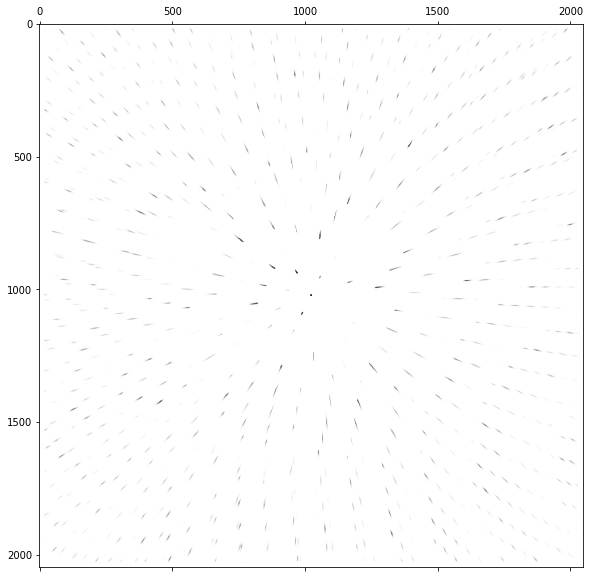

In [12]:
def render_still(wavelength, hmax, A, distance_cutoff, 
                     detector_ori, fast_axis, slow_axis, 
                 pixels, pixelsize, pixel_radius): 
    H = None
    Rh = None
    for h in np.arange(-hmax, hmax + 1):
        hplane = np.array(np.meshgrid(np.arange(-hmax, hmax+1, dtype=np.int8), 
                                 np.arange(-hmax, hmax+1, dtype=np.int8), 
                                 h)).reshape((3, (2*hmax+1)**2))
        rh = np.matmul(hplane.T, np.linalg.inv(A)) + [0 , 0, 1/wavelength]
        Dh = np.linalg.norm(rh, 2, 1)
        indices = (Dh  > 1/wavelength - distance_cutoff) & (Dh < 1/wavelength + distance_cutoff) & (rh[:,2] > 0)

        hplane = hplane[:,indices]
        rh = rh[indices]

        if H is not None:
            H = np.hstack((H, hplane))
            Rh = np.vstack((Rh, rh))
        else:
            H = hplane.copy()
            Rh = rh.copy()

    linear_systems = np.dstack((
        -Rh, 
        np.ones(Rh.shape)*fast_axis[None, :], 
        np.ones(Rh.shape)*slow_axis[None, :])).swapaxes(-1, -2)
    pixpos = np.matmul(-detector_ori, np.linalg.inv(linear_systems))/pixelsize
    pixpos = pixpos[:,1:]
    idx = np.all(pixpos >= pixel_radius, 1) & np.all(pixpos < pixels - pixel_radius - 1, 1)
    H,Rh,pixpos = H[:,idx],Rh[idx],pixpos[idx]

    I_sel = I_df.loc[map(tuple, H.T)].values.T[0]

    P = np.array(np.meshgrid(
        np.arange(pixels, dtype=floattype),
        np.arange(pixels, dtype=floattype)
    ))
    detector_basis = np.vstack((fast_axis, slow_axis))
    Rp = np.matmul(P.T, pixelsize*detector_basis) + detector_ori

    box = np.meshgrid(np.arange(-pixel_radius, pixel_radius), np.arange(-pixel_radius, pixel_radius))
    box = np.linalg.norm(box, 2, 0)
    box = (np.array(np.where(box <= pixel_radius)) - pixel_radius).astype(np.int8)

    idx = np.round(pixpos).astype(int)[:,:,None] + box[None,:,:]

    image = np.zeros((pixels, pixels))
    S1 = (Rp/np.linalg.norm(Rp, 2, 2)[:,:,None]/wavelength)
    image[idx[:,0,:], idx[:,1,:]] += I_sel[:,None] * np.exp(-np.square(np.linalg.norm(S1[idx[:,0,:], idx[:,1,:]] - Rh[:,None,:], 2, -1)/Rs))
    return image

def helper_function(wavelength):
    image = render_still(wavelength, hmax, A, 
         distance_cutoff, detector_ori, fast_axis, 
         slow_axis, pixels, pixelsize, pixel_radius)
    return image

#from time import time
#nproc=6
#start = time()
#with Pool(nproc) as p:
#    image = np.sum(weights[:,None,None]*p.map(helper_function, wavelengths), 0)
#stop = time()
#print(f"It took {stop-start} s to render this image on {nproc} cores.")
#
image = np.zeros((pixels, pixels))
for i in tqdm(range(len(wavelengths))):
    image += weights[i]*helper_function(wavelengths[i])
plt.figure(figsize=(10,10))
ax = plt.gca()
ax.matshow(np.log(1 + image), cmap='Greys')